In [1]:
import sys
sys.path.append('..')
import jax
from tqdm import tqdm
import jax.numpy as np
import equinox as eqx
import optax
import jax.random as jr
from einops import rearrange,reduce
from PDE.model.reaction_diffusion_advection.update import F
from PDE.model.solver.semidiscrete_solver import PDE_solver
from jaxtyping import Array, Float, Scalar
import time
import matplotlib.pyplot as plt

# Image classification with a neural PDE
- This notebook shows how to use a neural reaction-diffusion-advection PDE to classify images

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#x_train_flat = rearrange(x_train,"batches w h -> batches (w h)") / 255.0
#x_test_flat = rearrange(x_test,"batches w h -> batches (w h)") / 255.0
y_train_1hot = jax.nn.one_hot(y_train,num_classes=10,axis=-1)
y_test_1hot = jax.nn.one_hot(y_test,num_classes=10,axis=-1)
x_train = x_train /255.0
x_test = x_test /255.0



2024-07-23 16:13:50.495613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 16:13:50.495644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 16:13:50.496644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 16:13:51.529978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class PDE_Classifier(eqx.Module):
    pde_solver: PDE_solver
    classifier: list
    encoder: list
    def __init__(self,N_CHANNELS,PADDING="REPLICATE",key=jr.PRNGKey(int(time.time()))):
        keys = jr.split(key,4)
        func = F(N_CHANNELS,PADDING,dx=1.0,key=keys[0])
        self.pde_solver = PDE_solver(func)
        self.classifier = [
            eqx.nn.Conv2d(in_channels=N_CHANNELS,
                          out_channels=10,
                          kernel_size=1,
                          padding=0,
                          key=keys[1]),
            jax.nn.relu,
            eqx.nn.Conv2d(in_channels=10,
                          out_channels=10,
                          kernel_size=1,
                          padding=0,
                          key=keys[2]),
            lambda x: reduce(x,"c w h -> c","mean"),
            jax.nn.softmax
        ]
        self.encoder = [lambda x: rearrange(x,"w h -> () w h"),
                        eqx.nn.Conv2d(in_channels=1,
                                     out_channels=N_CHANNELS,
                                     kernel_size=1,
                                     padding=0,
                                     key=keys[3])]
    
    def iterate(self,
                ts: Float[Array, "T"],
                x: Float[Array, "c w h"])->Float[Array, "T c w h"]:
        _,xs = self.pde_solver(ts,x)
        return xs
    
    def __call__(self,
                 x: Float[Array, "w h"],
                 T: Float[Scalar, ""])->Float[Array, "10"]:
        for layer in self.encoder:
            x = layer(x)
        
        
        x = self.iterate(np.linspace(0,T,2),x)[-1] # Only return final time step
        
        for layer in self.classifier:
            x = layer(x)
        return x
    
    def partition(self):
        total_diff,total_static = eqx.partition(self,eqx.is_array)
        pde_diff,pde_static = self.pde_solver.partition()
        where_pde = lambda m:m.pde_solver
        total_diff = eqx.tree_at(where_pde,total_diff,pde_diff)
        total_static = eqx.tree_at(where_pde,total_static,pde_static)
        return total_diff,total_static

In [4]:
model = PDE_Classifier(N_CHANNELS=4,PADDING="REPLICATE")
diff,static = model.partition()

In [5]:
import operator
def safe_shape(x):
    try:
        return x.size
    except:
        return 0



#eqx.tree_pprint(eqx.filter(diff,eqx.is_array,replace=None))
print(jax.tree.reduce(operator.add,jax.tree.map(safe_shape,diff)))


348


In [6]:
y = model(x_train[10],1.0)
print(y)

/home/s1605376/.local/Spyder-5.4.3.dev0/envs/jax_cpu/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/s1605376/.local/Spyder-5.4.3.dev0/envs/jax_cpu/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/s1605376/.local/Spyder-5.4.3.dev0/envs/jax_cpu/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


[0.08515681 0.0590257  0.13095978 0.08204005 0.11325799 0.08649288
 0.10117029 0.13369726 0.10894896 0.09925028]


In [7]:
def loss(diff,static,x,y):
    model = eqx.combine(diff,static)
    v_model = eqx.filter_vmap(model,in_axes=(0,None),out_axes=0)
    y_pred = v_model(x,1.0)
    #print(y_pred.shape)
    return -np.sum(np.mean(y*np.log(y_pred),axis=0))

In [9]:
#print(loss(model,x_train[:20],y_train_1hot[:20]))

In [10]:
def train(model,TRAINING_STEPS,BATCH_SIZE):
    schedule = optax.exponential_decay(1e-3, transition_steps=TRAINING_STEPS, decay_rate=0.99)
    optimiser = optax.chain(optax.scale_by_param_block_norm(),
                            optax.nadam(schedule))
    
    @eqx.filter_jit
    def make_step(model,opt_state,x,y):
        diff,static = model.partition()
        loss_val,grad = jax.value_and_grad(loss)(diff,static,x,y)
        diff,static = model.partition()
        update, opt_state = optimiser.update(grad,opt_state,diff)    
        model = eqx.apply_updates(model,update)
        return model,opt_state,loss_val
    
    diff,static= model.partition()
    opt_state = optimiser.init(diff)
    loss_log = []
    key = jr.PRNGKey(int(time.time()))
    for i in tqdm(range(TRAINING_STEPS)):
        key = jr.fold_in(key,i)
        idx = jr.choice(key,np.arange(len(x_train)),(BATCH_SIZE,),replace=False)
        
        x = x_train[idx]
        y = y_train_1hot[idx]
        model,opt_state,loss_val = make_step(model,opt_state,x,y)
        #if i % 100 == 0:
        loss_log.append(loss_val)
        #tqdm.write(str(loss_val)
    return model,loss_log
    

In [11]:
model,losses = train(model,1000,64)

 28%|██▊       | 281/1000 [17:05<43:43,  3.65s/it]  


KeyboardInterrupt: 

[0.09189839 0.09013584 0.12673831 0.10905113 0.11635156 0.07653739
 0.10391693 0.06877954 0.09982715 0.11676373]


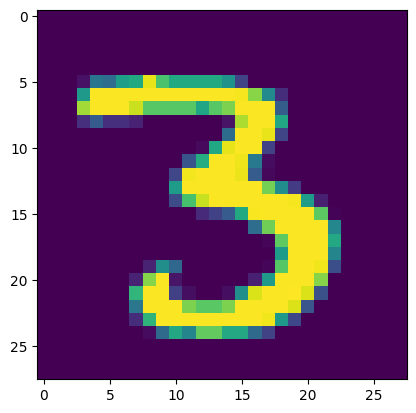

In [ ]:
print(model(x_train[12],1.0))
plt.imshow(x_train[12])